In [90]:
import pyfolio as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

# Portfolio Analysis for 401K

This is a first pass on the analysis of the 401K retirement options you have available. As mentioned, you have weights already in mind, but these can be reevaluated if necessary. 

This notebook is divided (right now) into three sections. In the first, I explain my data and do some rudimentary analysis of the assets. In the second, I calculate the calculate the performance of each asset and explain the meaning of the performance metrics. In the last section, I calculate the portfolio described to me over email and report its performance.

For my own sanity, I am listing the six ETF tickers here along with a description of each

- **VOO**: Vanguard S&P 500 ETF
- **IWD**: iShares Russell 1000 Value ETF
- **IWP**: iShares Russell Midcap Growth ETF
- **VNQ**: Vanguard Real Estate ETF
- **JPIN**: JPMorgan Diversified Return International Equity ETF
- **IWO**: iShares Russell 2000 Growth ETF

## General Framework

The data is daily and the time frame is from January 1, 2015 to June 1, 2019. I get my data from Yahoo Finance; this is worth noting because, with their data, the closing price is conveniently adjusted for dividends and stock splits.

Here, I read in the data and display the first few days of prices per each asset.

In [92]:
tickers = ['IWD', 'IWO', 'IWP', 'JPIN', 'VNQ', 'VOO']
dfs = [pd.read_csv('data/' + ticker + '.csv') for ticker in tickers]
closes = [pd.Series(df['Adj Close']) for df in dfs]
for i in range(len(closes)):
    closes[i].index = pd.to_datetime(dfs[i]['Date'])
closes_df = pd.concat(closes, axis=1)
closes_df.columns = tickers
closes_df = closes_df['2015-01-01':]
closes_df.head()

,IWD,IWO,IWP,JPIN,VNQ,VOO
Date,,,,,,
2015-01-02,93.945000,136.350571,89.249794,45.022976,68.552872,172.900635
2015-01-05,92.280762,134.740295,87.687370,45.022976,68.928070,169.862961
2015-01-06,91.408157,132.300827,86.680885,43.876774,69.611755,168.192688
2015-01-07,92.352730,134.306396,87.850319,43.876774,70.678986,170.294296
2015-01-08,93.981003,136.909805,89.479851,44.683697,70.945793,173.286087


Now, I plot all the prices as individual time series. Notice that many of them move in tandem. This can be problematic, as one goal as an investor is to increase diversification, but this benefit is greatly reduced if all assets are correlated.

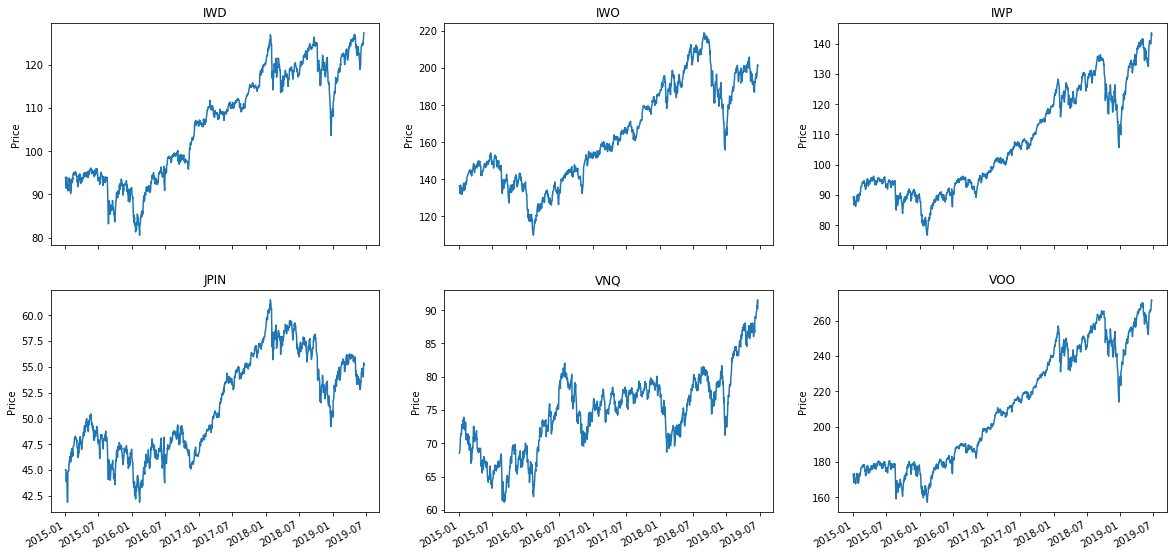

In [4]:
plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots(nrows=2, ncols=3)


i = 0
for row in ax:
    for col in row:
        col.plot(closes_df.iloc[:, i])
        col.set_title(tickers[i])
        col.set_ylabel('Price')
        i = i + 1


fig.autofmt_xdate()

### Returns

I now calculate the log returns and do some more exploratory data analysis. 

The intuitive calculation of returns is known as *arithmetic returns* (today's price divided by yesterday's price, minus one), but I am using *log returns* here for math reasons. When small, arithmetic and log returns are approximately equal.

Feel free to look into the real, formal definition of log returns, but - for the purposes of this very high level overview - think of it like this: if you compound twice annually, it's a greater return than once annually, and if you compound four times annually it's a greater return than twice annually; take that compounding frequency to infinity and you get log returns (also known as continuously compounded returns).

Here are the first few returns in the data set.

In [95]:
returns = np.log(closes_df).diff()[1:]
returns.head()

,IWD,IWO,IWP,JPIN,VNQ,VOO
Date,,,,,,
2015-01-05,-0.017874,-0.011880,-0.017661,0.000000,0.005458,-0.017725
2015-01-06,-0.009501,-0.018271,-0.011544,-0.025788,0.009870,-0.009882
2015-01-07,0.010281,0.015045,0.013401,0.000000,0.015215,0.012418
2015-01-08,0.017477,0.019199,0.018379,0.018224,0.003768,0.017416
2015-01-09,-0.009232,-0.007138,-0.007527,0.000000,0.000470,-0.008456


I didn't put these in "percentages" (multiply by 100) because it is a useless step and this works fine. So, for example, IWD closed down 1.8% on `2015-01-05` and up 1.7% on `2015-01-08`.

Just to prove again that the assets are all very correlated, see the actual calculation here. Notice the nearly perfect correlation between IWD, IWP, and VOO. The asset that provides the most diversification is VNQ, the REIT. 

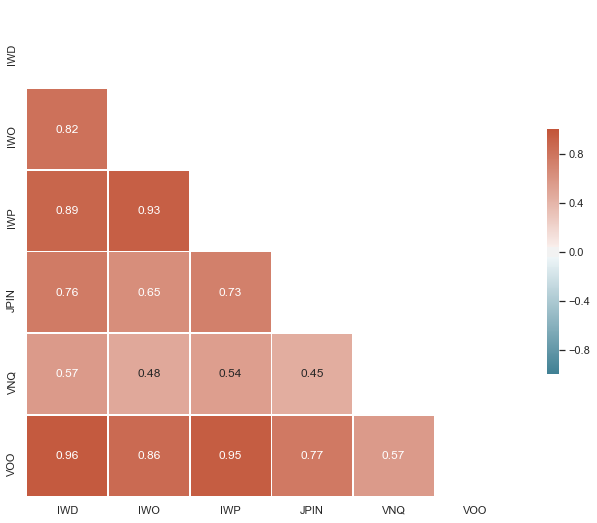

In [98]:
import seaborn as sns

corr = returns.corr()
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
    annot=True, fmt=".2f"
)

A more intuitive plot to illustrate correlation, for me, is to see the returns plotted against each other (each point represents a single day's return). So, for example, the top right cell shows that IWD and VOO have nearly perfect correlation and so the return on IWD can be almost exactly determined based on the day's return on VOO.

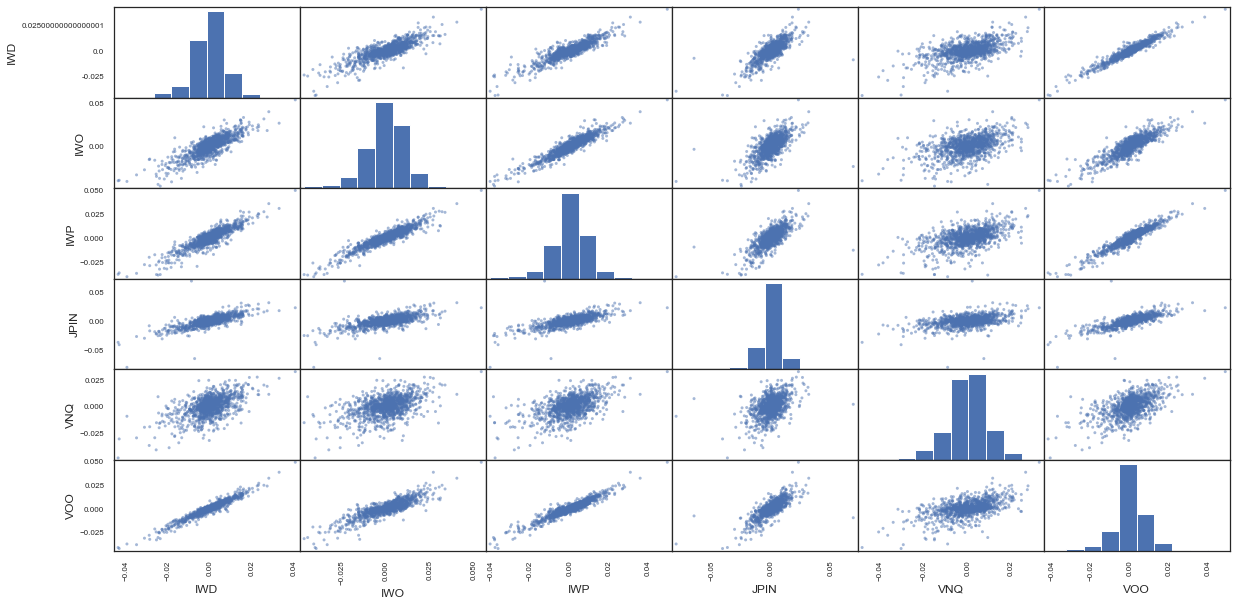

In [89]:
x = pd.plotting.scatter_matrix(returns)

## Performance

Now I will explore the performance of each asset and calculate various metrics of interest. The first question is, of course, the cumulative return of each asset over the course of the whole time frame. The standard way to demonstrate this uses what is called an equity curve - you can see the cumulative return over the whole period for every asset in a way that is easy for comparison. It appears the standard market instruments (VOO, IWP, and IWO) see the strongest return over this period.

In [143]:
import bokeh
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models.tools import HoverTool

cumsum_returns = np.cumsum(returns)

source = ColumnDataSource(data=cumsum_returns)

tools_to_show = 'box_zoom,save,hover,reset'


def datetime(x):
    return np.array(x, dtype=np.datetime64)

p1 = figure(x_axis_type="datetime", title="Equity Curve",
#             tools=tools_to_show,
#             tooltips=[("Aux", "$VOO")]
           )

p1.grid.grid_line_alpha=0.5
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = 'Cumulative Log Return'
p1.tools.append(hover_tool)

colors = {
    'IWD':'#FE0707',
    'IWO': '#FE7707',
    'IWP': '#049898',
    'JPIN': '#06CB06',
    'VNQ': '#FF6767',
    'VOO': '#FFAC67'
}

source = cumsum_returns
for ticker in tickers:
    p1.line(
        datetime(cumsum_returns.index),
        cumsum_returns[ticker],
        color=colors[ticker],
        legend=ticker,
        name=ticker,
#         source=source
    )
    
p1.legend.location = 'top_left'

output_notebook()
show(p1)

Loading BokehJS ...

Now for the more interesting metrics. This is actually the section you should look at most closely, as you you can figure out, in objective terms, whether or not the portfolio you choose performs better than the market when adjusted for risk. 

See the table below. In particular, the row labeled "Sharpe ratio" should be of most interest. This is the *risk adjusted* measure for a given asset/portfolio. Notice that the greatest value is with VOO, at 0.744. The second greatest is IWP (midcap stocks) and the least attractive is JPIN with 0.31 (JP Morgan international equity).

There are some other metrics worth calling out. Obviously, it is nice to look at the cumulative return - in this case, you would see a 50% return on VOO since 2015, which is good to simply keep in the back of one's head. 

I would call out the last row as being of interest as well - the daily value at risk (VaR) measures a "bad" outcome (in this case two standard deviations). So, in more intuitive terms, 5% of the time one can expect VOO to see a 1.67% decline in value or worse in a single day. I hope that makes sense.

Finally, max drawdown can let you know what to expect in a major downturn. It measures the greatest percent decline from the previous high. So, the worst drop in VOO from 2015 to the present was a 20% decline in value.

In [34]:
from pyfolio import plotting
from pyfolio import timeseries

returns.apply(timeseries.perf_stats, axis=0)

,IWD,IWO,IWP,JPIN,VNQ,VOO
Annual return,0.061451,0.073523,0.098640,0.035867,0.051572,0.096182
Cumulative returns,0.304733,0.372237,0.521346,0.170204,0.251439,0.506225
Annual volatility,0.131156,0.179469,0.149536,0.142861,0.150199,0.135866
Sharpe ratio,0.520455,0.485296,0.704153,0.318397,0.410126,0.744074
Calmar ratio,0.320709,0.246216,0.426250,0.173380,0.285663,0.482276
Stability,0.804728,0.668703,0.798981,0.538388,0.484284,0.886732
Max drawdown,-0.191610,-0.298613,-0.231414,-0.206872,-0.180536,-0.199434
Omega ratio,1.097430,1.085275,1.131296,1.059916,1.071087,1.147226
Sortino ratio,0.715995,0.663523,0.964132,0.433441,0.555425,1.031539
Skew,-0.515928,-0.415578,-0.532090,-0.739903,-0.556704,-0.461304


##  Performance of Provided Portfolio Weights

I will now look into the prespecified portfolio to see how it has historically performed against the market. This simply weights the daily returns in terms of what was given to me, so it can be thought of as daily rebalancing.

In [148]:
weights = pd.DataFrame(
    [0.4, 0.05, 0.05, 0.05, 0.05, 0.4],
    index=['IWD', 'IWO', 'IWP', 'JPIN', 'VNQ', 'VOO']
)
pfolio_returns = returns.dot(weights)

I will first plot the data as an equity curve versus VOO, again to simply allow comparison

In [150]:
import bokeh
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models.tools import HoverTool

cumsum_returns = np.cumsum(returns)

source = ColumnDataSource(data=cumsum_returns)

tools_to_show = 'box_zoom,save,hover,reset'


def datetime(x):
    return np.array(x, dtype=np.datetime64)

p1 = figure(x_axis_type="datetime", title="Equity Curve",)

p1.grid.grid_line_alpha=0.5
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = 'Cumulative Log Return'

colors = {
    'pfolio': '#FF6767',
    'VOO': '#FFAC67'
}
p1.line(
    datetime(cumsum_returns.index),
    cumsum_returns['VOO'],
    color=colors['VOO'],
    legend='VOO',
    name='VOO',
)

p1.line(
    datetime(cumsum_returns.index),
    np.cumsum(pfolio_returns)[0],
    color=colors['pfolio'],
    legend='Portfolio',
    name='pfolio',
)


p1.legend.location = 'top_left'

output_notebook()
show(p1)

Loading BokehJS ...

It does seem that going with VOO alone would provide a better return, but this is also likely plain randomness and should not be considered a horrible outcome. Here are the metrics as decribed in the last section.

In [157]:
df = pd.concat([pfolio_returns, returns], axis=1)
df = df.rename(columns={ df.columns[0]: "pfolio" })
df.apply(timeseries.perf_stats, axis=0)

,pfolio,IWD,IWO,IWP,JPIN,VNQ,VOO
Annual return,0.076975,0.061451,0.073523,0.098640,0.035867,0.051572,0.096182
Cumulative returns,0.392027,0.304733,0.372237,0.521346,0.170204,0.251439,0.506225
Annual volatility,0.130641,0.131156,0.179469,0.149536,0.142861,0.150199,0.135866
Sharpe ratio,0.633153,0.520455,0.485296,0.704153,0.318397,0.410126,0.744074
Calmar ratio,0.401230,0.320709,0.246216,0.426250,0.173380,0.285663,0.482276
Stability,0.849113,0.804728,0.668703,0.798981,0.538388,0.484284,0.886732
Max drawdown,-0.191848,-0.191610,-0.298613,-0.231414,-0.206872,-0.180536,-0.199434
Omega ratio,1.121824,1.097430,1.085275,1.131296,1.059916,1.071087,1.147226
Sortino ratio,0.872111,0.715995,0.663523,0.964132,0.433441,0.555425,1.031539
Skew,-0.509669,-0.515928,-0.415578,-0.532090,-0.739903,-0.556704,-0.461304


Now that we can compare this portfolio objectively versus the market, it is more apparent that the plain S&P 500 is superior. Notice that with the weighted strategy the Sharpe ratio is reduced, the annual return and cumulative are less, and that the volatility is roughly the same. However, there are some interesting results with the daily value at risk being slightly reduced and the max drawdown being a little less severe as well.

## Conclusions and Next Steps

The primary conclusion is that the S&P 500 has pretty damn good returns. However, as I suspected initially, the limitation of this analysis is correlation among assets. I believe there is added value in seeking more ETF choices that could better diversify this portfolio. Take a look at the scatter plot for the REIT ETF - this kind of lower correlation means that the portfolio on the whole can see reduced risk (though I will not explain why right now). Additionally, as a not-old person you can afford to take more serious risk, so consider highly aggressive ETF choices such as QQQ or a tech sector ETF.

Finally, there are other, more interesting analysis that can be done. Namely, the optimal weights can easily be calculated for a minimum variance portfolio or a maximized Sharpe ratio portfolio. This can provide more insight.Out of sample testing is another consideration (just because a portfolio performed well in the past doesn't mean it will continue to do so in the future). These more technical pursuits are what I will keep plugging away with, but I would rather go to sleep right now.